# Training from Selfplay Data
### Current status
---

#### Generalization
The current architecture converges to perfect overfit on up to 1000 samples in 50% of the training runs. In the other cases it hits a plateau from which it apparently can't escape. 1000 episodes are sufficient to distinguish the cases. The generalization looks somewhat reasonable: On unseen boards, the policy recommends few positions in populated, but not necessarily critical areas but hardly ever even closely match the labels. Also, occupied fields are recommended at times.

#### More Parameters
Adding more layers/filters does not help convergence

#### Loss function alternatives
I tried $p \cdot ( y - p )^2$ which would prefer to match positions with higher labels, so that the policy doesn't waste time on perfectly fitting the zeros. But it didn't work. It appears that not even MSE works. I believe that - from a numerical standpoint - the policy's softmax requires cross entropy

#### Conclusion
We are currently unable to train a neural network to better advise the MCTS better than the heuristic - we're not even coming close.

#### Other Findings
The MCTS policy labels are very tight. Once we solved the training issues, the policy labels may encourage more exploration? It's not the policy's job to find the best move but to identify the set of moves worth considering. The MCTS will do the rest

We are far from understanding this part of the problem.

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
from aegomoku.game_data import read_training_data
from aegomoku.utils import analyse_example

In [27]:
BOARD_SIZE=15
filename = "the_heuristic_fourty.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape

(8288, 3, (17, 17, 3))

---
### Data Verification
We have 8288 records from 40 games in 8 symmetries. Now we skim through a good chunk of training records to check whether it makes sense (to some degree).

In [28]:
i = 0

Next to play: WHITE
Value from WHITE's point of view: 0.014980288100011667


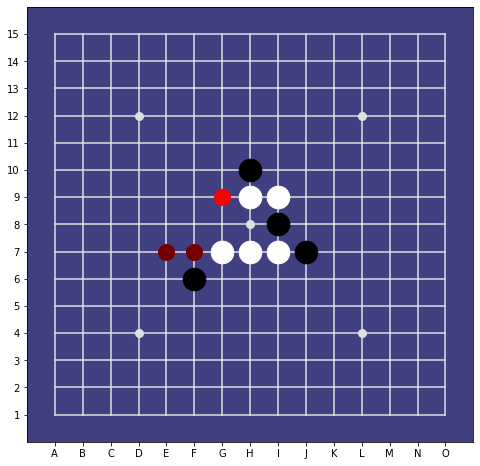

In [32]:
import random

analyse_example(BOARD_SIZE, examples[random.randint(0, 8288)])

In [6]:
import numpy as np
from aegomoku.game_data import read_training_data
from aegomoku.utils import analyse_example

In [7]:
BOARD_SIZE=15
filename = "the_heuristic_fourty.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape

(8288, 3, (17, 17, 3))

In [13]:
from aegomoku.gomoku_model import NeuralNetAdapter

the_model = NeuralNetAdapter(BOARD_SIZE + 2)
the_model.policy.compile()
#the_model.policy.summary()

In [14]:
sample = np.expand_dims(examples[55][0], axis=0).astype(float)
print(sample.shape)
import aegomoku.tools as gt
#gt.print_channels(sample)
p, v = the_model.policy(sample)

(1, 17, 17, 3)


In [15]:
import keras.backend as k
import tensorflow as tf
y_t = examples[55][1]
y = tf.cast(y_t, tf.float32)
k.sum(y * (p - y) * (p - y), axis=1)
from aegomoku.gomoku_model import special_loss
special_loss(y_t, p)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1805195], dtype=float32)>

In [16]:
N=200
the_model.train(examples[:N], epochs_per_train=1000, report_every=100)

Epoch: 1, Training: 6.291921138763428, Test: 0.0
Epoch: 101, Training: 4.739750385284424, Test: 0.0
Epoch: 201, Training: 4.6196417808532715, Test: 0.0
Epoch: 301, Training: 4.378006935119629, Test: 0.0
Epoch: 401, Training: 3.788533926010132, Test: 0.0
Epoch: 501, Training: 3.353003978729248, Test: 0.0
Epoch: 601, Training: 3.051050901412964, Test: 0.0
Epoch: 701, Training: 2.831488609313965, Test: 0.0
Epoch: 801, Training: 2.6520447731018066, Test: 0.0
Epoch: 901, Training: 2.4803402423858643, Test: 0.0
Epochs: 1000, Loss: 2.3421027660369873, 


(1, 17, 17, 3)
n=184
Next to play: BLACK
Value from BLACK's point of view: 0.9491280979189832
value = 0.9491280979189832
Next to play: BLACK
Value from BLACK's point of view: [[0.78910816]]
value = [[0.78910816]]


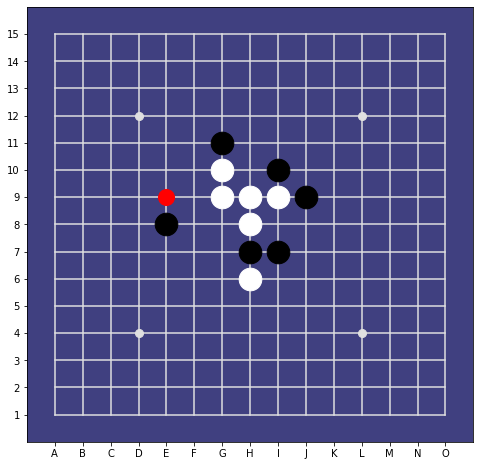

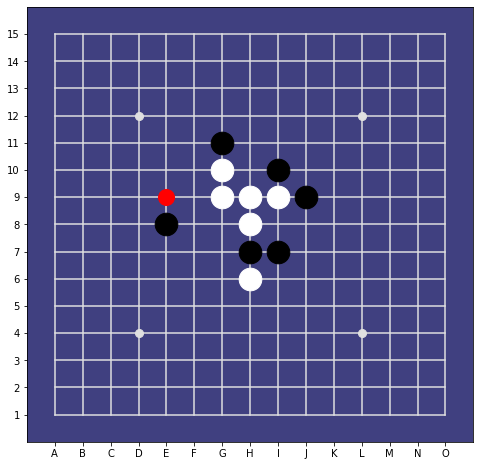

In [24]:
n = random.randint(0, 2*N)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
print(sample.shape)
p_, v_ = the_model.policy(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), v_)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
print(f"value = {v}")
analyse_example(BOARD_SIZE, example)
print(f"value = {v_}")